# Определение возраста покупателей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.data import Dataset
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

---

*Глобальная цель* - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы

*Цель проекта* - создание модели компьютерного зрения, которая сможет приблизительно оценивать возраст покупателей у кассы

В качестве датасета используется [APPA-REAL](https://chalearnlap.cvc.uab.cat/dataset/26/description/) датасет

## Загрузка данных

Данные находятся в папке 'data'. Были обычные фотографии и обработанные (лица людей в центре и правильно повернуты). В датасете оставили только обработанные фотографии. Информация о возрасте хранится в csv файлах

In [2]:
df = pd.read_csv('./data/train.csv')
df.head(5)

,file_name,real_age,apparent_age,worker_age,worker_gender
0,000000.jpg,4,5,36,male
1,000000.jpg,4,4,38,female
2,000000.jpg,4,7,52,female
3,000000.jpg,4,5,50,male
4,000000.jpg,4,4,52,female


In [3]:
def get_data(data_type):
    path = './data/' + data_type + '.csv'
    return pd.read_csv(path)[['file_name', 'real_age']].drop_duplicates().set_index('file_name')

In [4]:
train_data = get_data('train')
valid_data = get_data('valid')
test_data = get_data('test')

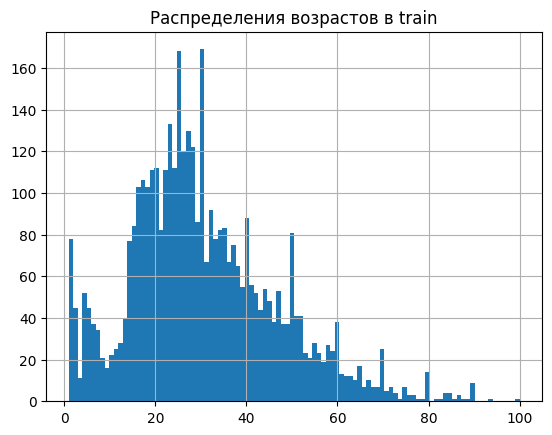

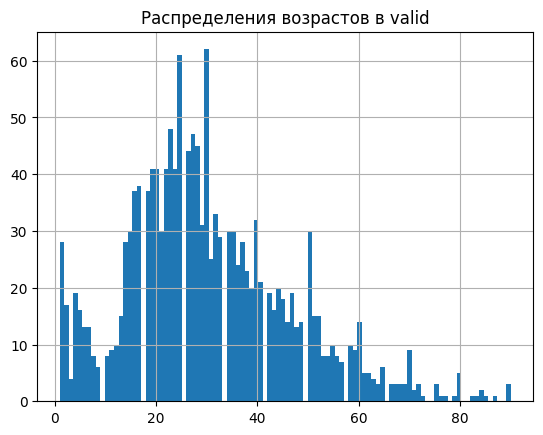

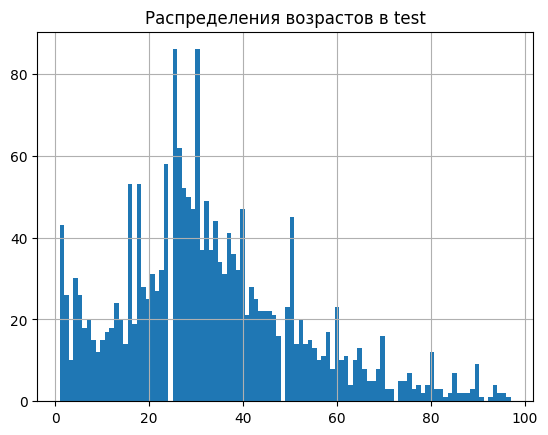

In [5]:
train_data.hist('real_age', bins=100, ax=plt.gca())
plt.title('Распределения возрастов в train')
plt.show()
valid_data.hist('real_age', bins=100, ax=plt.gca())
plt.title('Распределения возрастов в valid')
plt.show()
test_data.hist('real_age', bins=100, ax=plt.gca())
plt.title('Распределения возрастов в test')
plt.show()

### Dataset pipeline

In [6]:
sample_path = 'data/train/000000.jpg'

In [7]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    input_image = tf.cast(image, tf.float32)
    return input_image

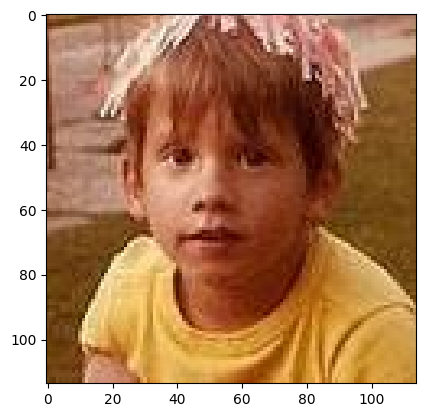

In [8]:
sample_image = load_image(sample_path)

plt.imshow(sample_image / 255.0)

In [9]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
BUFFER_SIZE = 400

In [10]:
def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, (height, width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

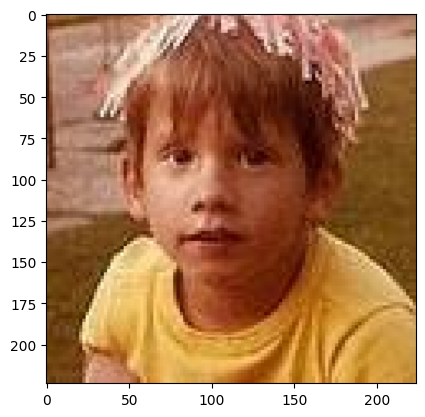

In [11]:
resized_sample_image = resize(sample_image, IMG_HEIGHT, IMG_WIDTH)

plt.imshow(resized_sample_image/255.0)

In [12]:
@tf.function()
def augmentations(input_image):
    if tf.random.uniform(()) < 0.5:
        input_image = tf.image.flip_left_right(input_image)
    
    return input_image

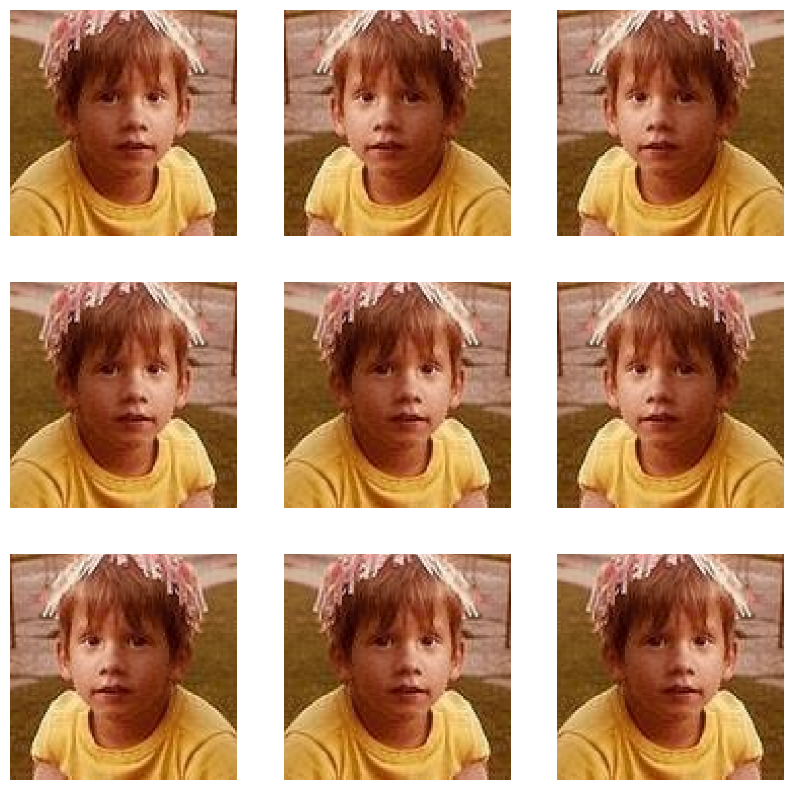

In [13]:
# test augmentations

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmentations(resized_sample_image)/255.0)
    plt.axis('off')

In [14]:
def load_image_train(image_path, label):
    input_image = load_image(image_path)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    input_image = augmentations(input_image)
    return input_image, label

In [15]:
def load_image_test(image_path, label):
    input_image = load_image(image_path)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    return input_image, label

In [16]:
def get_dataset(ds_type, labels, subset='train'):
    path = './data/' + ds_type + '/*.jpg'
    dataset = Dataset.list_files(path, shuffle=False)
    dataset = Dataset.zip((dataset, Dataset.from_tensor_slices(labels)))
    if subset == 'train':
        dataset = dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(BUFFER_SIZE)
    else:
        dataset = dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [17]:
train_dataset = get_dataset('train', train_data['real_age'])
valid_dataset = get_dataset('valid', valid_data['real_age'], 'test')
test_dataset = get_dataset('test', test_data['real_age'], 'test')

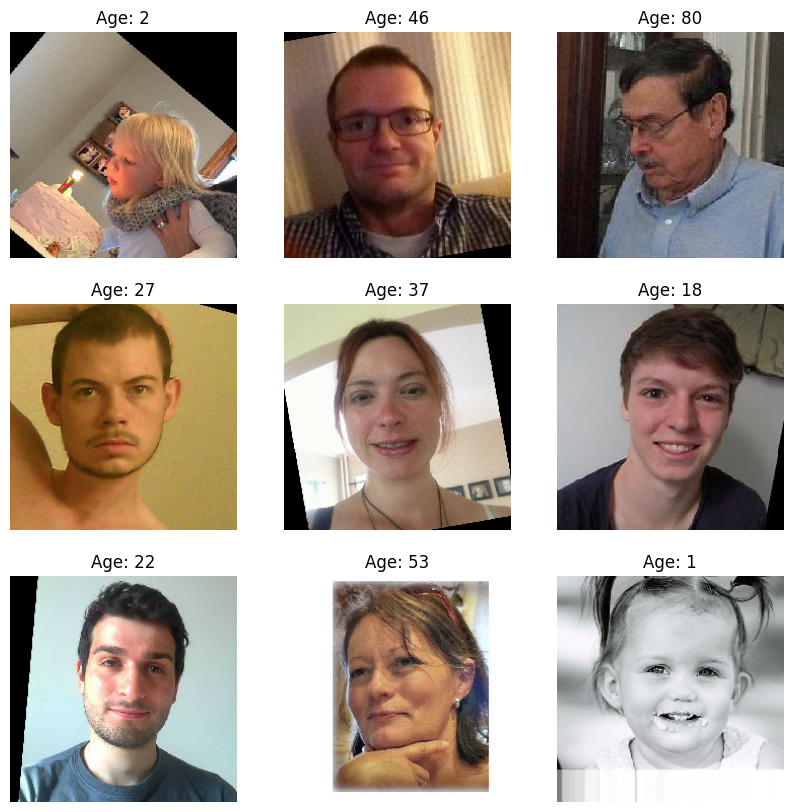

In [18]:
plt.figure(figsize=(10, 10))

for images, labels in valid_dataset.take(2):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i]/255.0)
        plt.title(f'Age: {labels[i]}')
        plt.axis('off')

## Model

Возьмем модель ResNet50. Обучение будет происходить в 2 этапа: Обучение последнего слоя и fine tuning. 

In [19]:
def generate_model(lr=0.0001):
    base_model = ResNet50(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='relu')(x)
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    return model

In [26]:
def create_callbacks():
    curr_date = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    checkpoint_path = 'checkpoints/' + curr_date + '/cp-{epoch:02d}.ckpt'

    cp_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=0,
        save_best_only=True
    )
    
    return cp_callback, TensorBoard()

In [27]:
def recompile(model, finetune_layers=100, lr=0.00001):
    base_model = model.get_layer('resnet50')
    base_model.trainable = True
    if finetune_layers != 'all':
        for layer in base_model.layers[:finetune_layers]:
            layer.trainable=False
    
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=lr),
        metrics=['mean_absolute_error']
    )

In [31]:
def train_model(init_epochs=20, add_epochs=5):
    
    model = generate_model()
    print("*** Начинаем оценку модели перед обучением ***")
    eval_res = model.evaluate(valid_dataset)[1]
    print(f'MAE = {eval_res}')
    
    callbacks = create_callbacks()
    
    print("*** Начинаем обучение! ***")
    history_1 = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=init_epochs,
        callbacks=callbacks
    )
    
    recompile(model)
    
    print("*** Начинаем fine tuning! ***")
    add_history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        initial_epoch=init_epochs,
        epochs=init_epochs + add_epochs,
        callbacks=callbacks
    )
    
    print("Тестируем модель!")
    test_res = model.evaluate(test_dataset)[1]
    print(f"MAE = {test_res}")
    
    return history_1, add_history

In [32]:
h1, h2 = train_model()

*** Начинаем оценку модели перед обучением ***
47/47 [==============================] - 4s 71ms/step - loss: 1188.6395 - mean_absolute_error: 30.3964
MAE = 30.396406173706055
*** Начинаем обучение! ***
Epoch 1/20
129/129 [==============================] - 19s 132ms/step - loss: 918.3090 - mean_absolute_error: 25.6260 - val_loss: 656.3563 - val_mean_absolute_error: 20.8572
Epoch 2/20
129/129 [==============================] - 17s 130ms/step - loss: 529.7926 - mean_absolute_error: 17.9789 - val_loss: 420.3648 - val_mean_absolute_error: 15.6740
Epoch 3/20
129/129 [==============================] - 17s 130ms/step - loss: 379.4348 - mean_absolute_error: 14.7271 - val_loss: 338.4191 - val_mean_absolute_error: 13.9510
Epoch 4/20
129/129 [==============================] - 17s 131ms/step - loss: 329.8233 - mean_absolute_error: 13.7710 - val_loss: 311.8981 - val_mean_absolute_error: 13.5057
Epoch 5/20
129/129 [==============================] - 17s 131ms/step - loss: 311.8695 - mean_absolute_erro

## Выводы

Были загружены данные, создан пайплайн для датасета, скомпилирована модель на основе ResNet50